In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.interpolate import griddata
import os
import matplotlib as mpl
import tarfile
from discretize import TensorMesh
from discretize.utils import active_from_xyz
from SimPEG.utils import plot2Ddata, model_builder
from SimPEG.potential_fields import gravity
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)


In [38]:
data = np.loadtxt('data/Gravity_UTM.txt')
utm_x = np.array(data[:,0])
utm_y = np.array(data[:,1])
CBA = np.array(data[:,2])
receiver_locations = data[0:,2]
print(receiver_locations)

[-208.198 -208.194 -207.94  ... -196.585 -210.935 -214.312]


In [4]:
xi = np.linspace(min(utm_x), max(utm_x), 50)
yi = np.linspace(min(utm_y), max(utm_y), 50)
xi, yi = np.meshgrid(xi, yi)

# Interpolation
zi = griddata((utm_x,utm_y),CBA,(xi,yi))

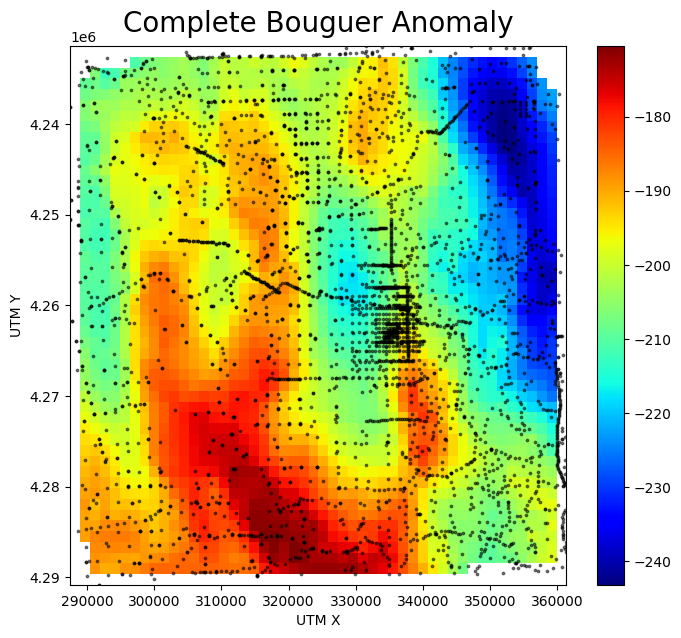

In [5]:
# Min max coordinates
xmin, xmax = min(utm_x), max(utm_x)
ymin, ymax = min(utm_y), max(utm_y)

plt.figure(figsize=(8,7))

plt.scatter(utm_x, utm_y, s=3, color='black', alpha=0.5) # Plot stations
plt.imshow(zi, aspect='auto', extent=(xmin,xmax,ymax,ymin), cmap='jet')
plt.title("Complete Bouguer Anomaly", size=20, pad=10)
plt.xlabel("UTM X"); plt.ylabel("UTM Y")
plt.colorbar()

plt.show()

In [6]:
def SVD2D(xi, yi, zi):
  m, n = xi.shape

  # First derivative of g to x
  f2dx_arr = []
  for i in range (0,m-1):
    for j in range (0,n-1):
      fd=(zi[i+1][j+1]-zi[i][j])/(xi[i+1][j+1]-xi[i][j])
      f2dx_arr.append(float(fd))
  g_first_x = np.reshape(f2dx_arr, (m-1,n-1))

  # Calculate new x coordinates for g'(x)      
  x2d_arr = []
  for i in range(0,m-1):
      for j in range (0,n-1):
        xd=(xi[i+1][j+1]-xi[i][j]) * 0.5
        x2d_arr.append(float(xd))

  x_first = np.reshape(x2d_arr, (m-1,n-1))
  x_new = xi[:-1,:-1]
  x_first = x_new+x_first

  # First derivative of g to y
  f2dy_arr = []
  for i in range (0,m-1):
    for j in range (0,n-1):
      fd=(zi[i][j]-zi[i+1][j])/(yi[i][j]-yi[i+1][j])
      f2dy_arr.append(float(fd))  
  g_first_y = np.reshape(f2dy_arr, (m-1,n-1))

  # Calculate new y coordinates for g'(y)
  y2d_arr = []
  for i in range(0,m-1):
      for j in range (0,n-1):
        yd=(yi[i][j]-yi[i+1][j]) * 0.5
        y2d_arr.append(float(yd))

  y_first = np.reshape(y2d_arr, (m-1,n-1))
  y_new = yi[:-1,:-1]
  y_first = y_new+y_first

  # Total of first derivatives
  g_first = g_first_x + g_first_y

  # Second derivative of g to x
  s2dx_arr = []
  for i in range (0,m-2):
    for j in range (0,n-2):
      sd=(g_first[i+1][j+1]-g_first[i][j])/(x_first[i+1][j+1]-x_first[i][j])
      s2dx_arr.append(float(sd))
  g_second_x = np.reshape(s2dx_arr, (m-2,n-2))

  # Calculate new coordinates for g"(x)
  x2dd_arr = []
  for i in range(0,m-2):
      for j in range (0,n-2):
        xdd=(x_first[i+1][j+1]-x_first[i][j]) * 0.5
        x2dd_arr.append(float(xdd))

  x_second = np.reshape(x2dd_arr, (m-2,n-2))
  x_new = x_first[:-1,:-1]
  x_second = x_new+x_second  

  # Second derivative of g to y
  s2dy_arr = []
  for i in range (0,m-2):
    for j in range (0,n-2):
      sd=(g_first[i][j]-g_first[i+1][j])/(y_first[i][j]-y_first[i+1][j])
      s2dy_arr.append(float(sd))  
  g_second_y = np.reshape(s2dy_arr, (m-2,n-2))

  # Calculate new coordinates for g"(y)
  y2dd_arr = []
  for i in range(0,m-2):
      for j in range (0,n-2):
        ydd=(y_first[i][j]-y_first[i+1][j]) * 0.5
        y2dd_arr.append(float(ydd))

  y_second = np.reshape(y2dd_arr, (m-2,n-2))
  y_new = y_first[:-1,:-1]
  y_second = y_new+y_second  

  # Total of second derivatives
  g_second = g_second_x + g_second_y

  # Residual anomaly (-g"). Convert mgal/m2 to mgal/km2
  res = -1 * g_second * 1e6

  # Re-gridding CBA to shape (m-2,n-2) because residual has lost shape
  CBA_regrid = griddata((utm_x,utm_y),CBA,(x_second,y_second))

  # Regional. CBA minus residual
  reg = CBA_regrid - res

  return res, reg, CBA_regrid

In [7]:
# Calculate 2D Second Vertical Derivative
res, reg, CBA_regrid = SVD2D(xi, yi, zi)

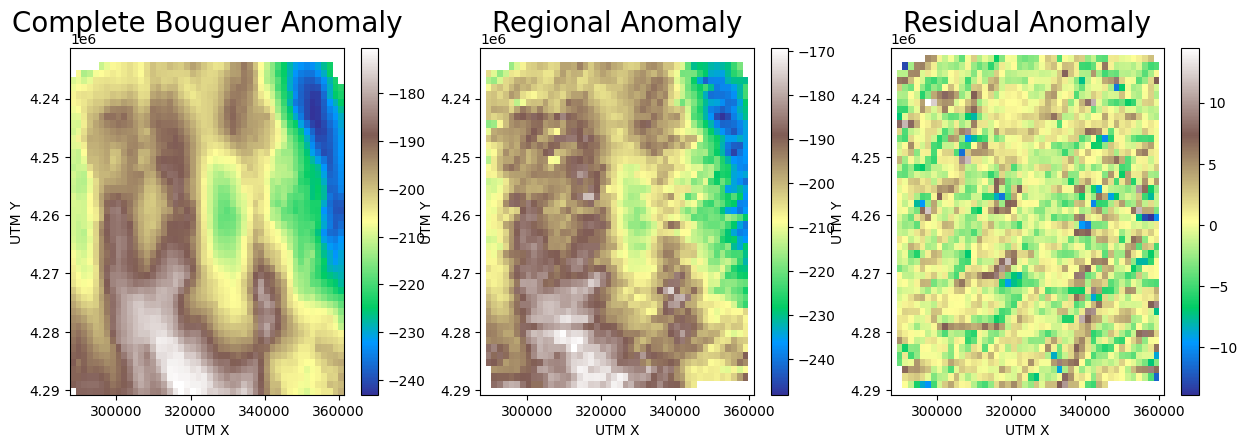

In [10]:
# Min max coordinates
xmin, xmax = min(utm_x), max(utm_x)
ymin, ymax = min(utm_y), max(utm_y)

# Grid map
plt.figure(figsize=(15,4.5))

plt.subplot(1,3,1)
plt.imshow(CBA_regrid, aspect='auto', extent=(xmin,xmax,ymax,ymin), cmap='terrain')
plt.title('Complete Bouguer Anomaly', size=20, pad=12)
plt.xlabel('UTM X'); plt.ylabel('UTM Y')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(reg, aspect='auto', extent=(xmin,xmax,ymax,ymin), cmap='terrain')
plt.title('Regional Anomaly', size=20, pad=12)
plt.xlabel('UTM X'); plt.ylabel('UTM Y')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(res, aspect='auto', extent=(xmin,xmax,ymax,ymin), cmap='terrain')
plt.title('Residual Anomaly', size=20, pad=12)
plt.xlabel('UTM X'); plt.ylabel('UTM Y')
plt.colorbar()

plt.show()

In [12]:
def makeSlice(xi, yi, zi, orientation='EW', loc=10):
  if orientation=='EW':
    # E-W slice
    x_slice = xi[loc]
    y_slice = yi[loc]
    g_slice = zi[loc]

  if orientation=='NS':
    x_slice = []
    for k in range(len(xi)):
      xslice = xi[k][loc]
      x_slice.append(float(xslice))
    x_slice = np.array(x_slice)

    y_slice = []
    for k in range(len(xi)):
      yslice = yi[k][k]
      y_slice.append(float(yslice))
    y_slice = np.array(y_slice)

    g_slice = []
    for k in range(len(xi)):
      gslice = zi[k][loc]
      g_slice.append(float(gslice))
    g_slice = np.array(g_slice)

  if orientation=='SWNE':
    # SW-NE slice
    x_slice = np.array(xi[0])

    y_slice = []
    for k in range(len(x_slice)):
      yslice = yi[k][k]
      y_slice.append(float(yslice))
    y_slice = np.array(y_slice)

    g_slice = []
    for k in range(len(x_slice)):
      gslice = zi[k][k]
      g_slice.append(float(gslice))
    g_slice = np.array(g_slice) 

  if orientation=='SENW':
    # SE-NW slice
    x_slice = np.array(xi[0])

    y_slice = []
    for k, j in zip(reversed(range(len(x_slice))), (range(len(x_slice)))):
      yslice = yi[k][j]
      y_slice.append(float(yslice))
    y_slice = np.array(y_slice)

    g_slice = []
    for k, j in zip(reversed(range(len(x_slice))), (range(len(x_slice)))):
      gslice = zi[k][j]
      g_slice.append(float(gslice))
    g_slice = np.array(g_slice)

  return x_slice, y_slice, g_slice

In [13]:
# Make 2D slices
SWNE = makeSlice(xi, yi, zi, orientation='SWNE')
SENW = makeSlice(xi, yi, zi, orientation='SENW')
EW1 = makeSlice(xi, yi, zi, orientation='EW', loc=10)
EW2 = makeSlice(xi, yi, zi, orientation='EW', loc=zi.shape[0]//2) # Centre
EW3 = makeSlice(xi, yi, zi, orientation='EW', loc=40)

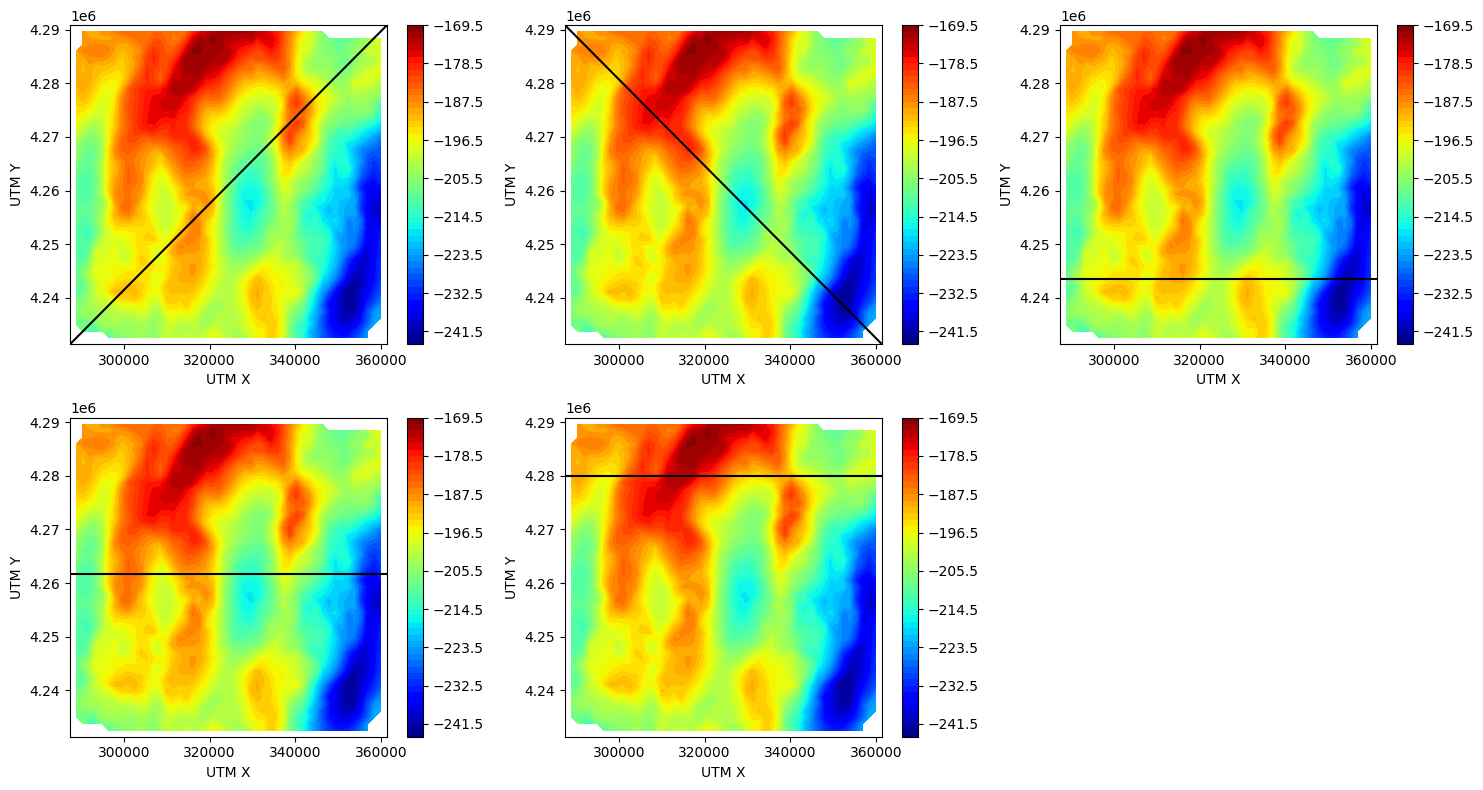

In [16]:
# Plot lines on grid map
data = [SWNE, SENW, EW1, EW2, EW3]

plt.figure(figsize=(15,8))

for i in range(5):
  plt.subplot(2,3,i+1)
  plt.contourf(xi, yi, zi, levels=50, cmap="jet")
  plt.plot(data[i][0], data[i][1], color='black')
  plt.xlabel("UTM X"); plt.ylabel("UTM Y")
  plt.colorbar()

plt.tight_layout()
plt.show()

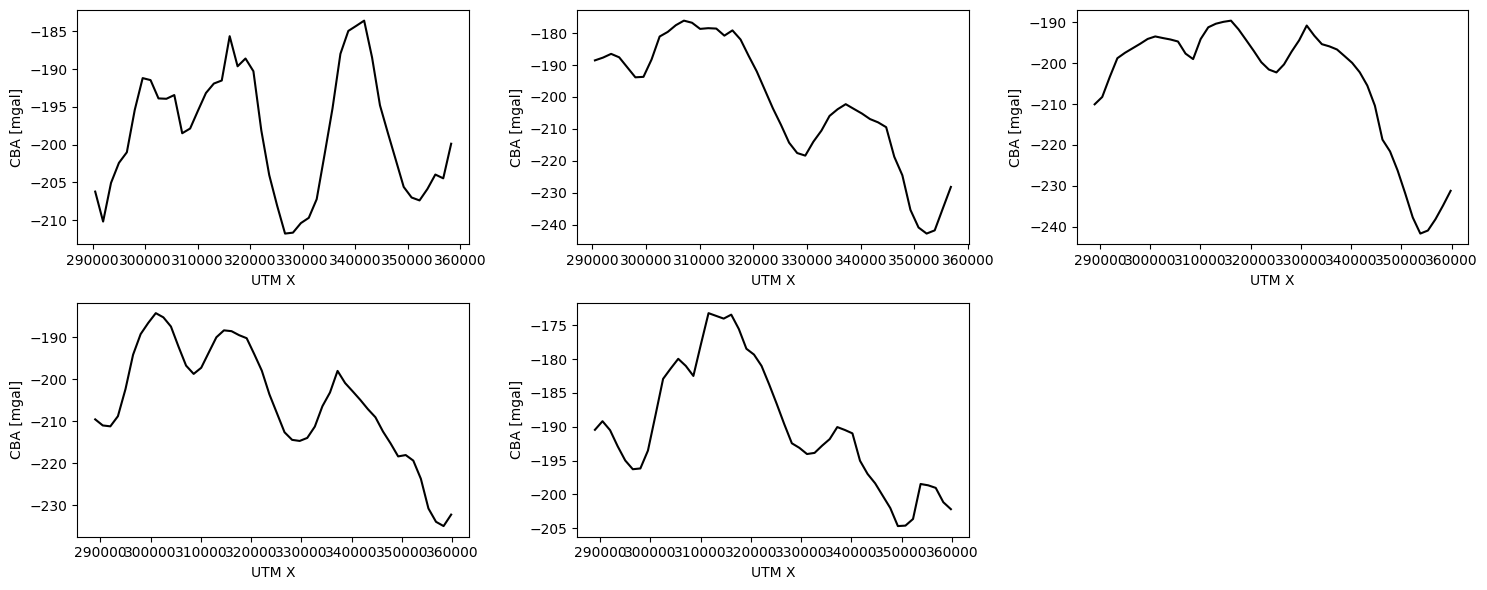

In [18]:
# Plot CBA over UTM X
data = [SWNE, SENW, EW1, EW2, EW3]

plt.figure(figsize=(15,6))

for i in range(5):
  plt.subplot(2,3,i+1)
  plt.plot(data[i][0], data[i][2], color='black')
  plt.xlabel("UTM X"); plt.ylabel("CBA [mgal]")

plt.tight_layout()
plt.show()

In [19]:
def distanceAxis(slice):
  x_slice, y_slice, g_slice = slice
  xd, yd = np.diff(x_slice)**2, np.diff(y_slice)**2
  d = np.sqrt(xd + yd)
  d = np.append(0, np.cumsum(d))
  return d, g_slice

In [20]:
# Transform (x,y,slice) to (distance,slice)
SWNE_t = distanceAxis(SWNE)
SENW_t = distanceAxis(SENW)
EW1_t = distanceAxis(EW1)
EW2_t = distanceAxis(EW2)
EW3_t = distanceAxis(EW3)

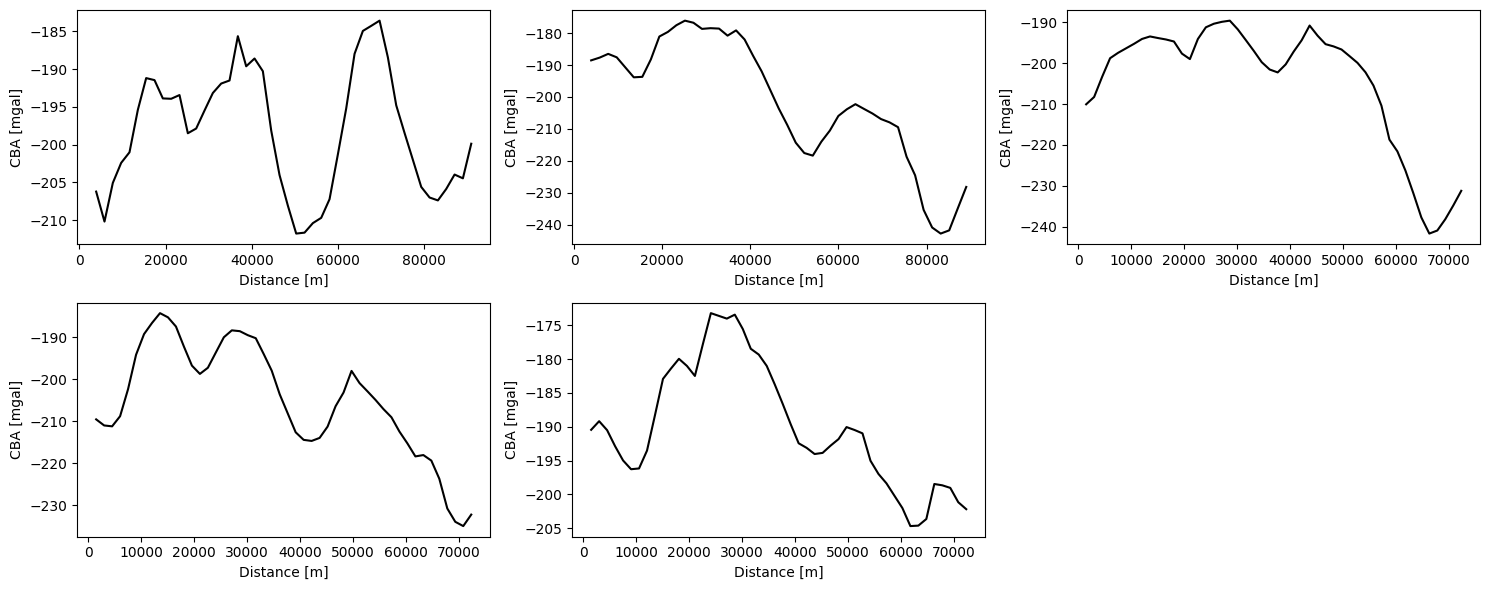

In [22]:
# Plot CBA over Distance
data = [SWNE_t, SENW_t, EW1_t, EW2_t, EW3_t]

plt.figure(figsize=(15,6))

for i in range(5):
  plt.subplot(2,3,i+1)
  plt.plot(data[i][0], data[i][1], color='black')
  plt.xlabel("Distance [m]"); plt.ylabel("CBA [mgal]")

plt.tight_layout()
plt.show()

In [23]:
def createDataframe(slice):
  x_slice, y_slice, g_slice = slice
  d, g_slice = distanceAxis(slice)
  # Drop NaN values
  return pd.DataFrame({'UTM X': x_slice, 'UTM Y': y_slice,
                       'Distance': d, 'CBA': g_slice}).dropna().reset_index(drop=True)

In [24]:
# Make dataframe
SWNE_df = createDataframe(SWNE)
SENW_df = createDataframe(SENW)
EW1_df = createDataframe(EW1)
EW2_df = createDataframe(EW2)
EW3_df = createDataframe(EW3)

EW1_df.head(10)

,UTM X,UTM Y,Distance,CBA
0,288964.640341,4.243502e+06,1507.455641,-210.069323
1,290472.095982,4.243502e+06,3014.911282,-208.274248
2,291979.551622,4.243502e+06,4522.366922,-203.364436
3,293487.007263,4.243502e+06,6029.822563,-198.803842
4,294994.462904,4.243502e+06,7537.278204,-197.488763
5,296501.918545,4.243502e+06,9044.733845,-196.388274
6,298009.374186,4.243502e+06,10552.189486,-195.288319
7,299516.829827,4.243502e+06,12059.645127,-194.098914
8,301024.285467,4.243502e+06,13567.100767,-193.487460
9,302531.741108,4.243502e+06,15074.556408,-193.875588


In [34]:
maximum_anomaly = np.max(np.abs(zi))

uncertainties = 0.01 * maximum_anomaly * np.ones(np.shape(dobs))

In [36]:
# Define the receivers. The data consists of vertical gravity anomaly measurements.
# The set of receivers must be defined as a list.
receiver_list = gravity.receivers.Point(receiver_locations, components="gz")

receiver_list = [receiver_list]

# Define the source field
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Define the survey
survey = gravity.survey.Survey(source_field)

# Second Vertical Derivative Technique in Gravity Regional and Residual Separation

In [41]:
coordx = np.array([[1,2,3,4,5], [1,2,3,4,5], [1,2,3,4,5], [1,2,3,4,5], [1,2,3,4,5]])
coordy = np.array([[1,1,1,1,1], [2,2,2,2,2], [3,3,3,3,3], [4,4,4,4,4], [5,5,5,5,5]])
bouguer = np.array([[10,22,34,46,58], [24,26,28,22,24], [34,26,42,54,38], [40,42,44,46,48], [51,53,55,57,59]])
print("Shape of X coordinate after gridding:", coordx.shape)
print("Shape of Y coordinate after gridding:", coordy.shape)
print("Shape of Bouguer after gridding:", bouguer.shape)

Shape of X coordinate after gridding: (5, 5)
Shape of Y coordinate after gridding: (5, 5)
Shape of Bouguer after gridding: (5, 5)


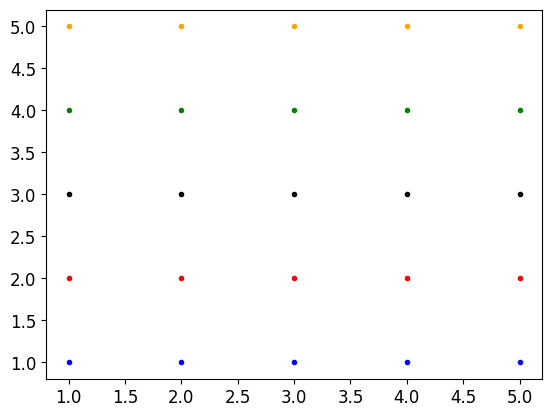

In [42]:
plt.plot(coordx[0], coordy[0], '.', color='blue')
plt.plot(coordx[1], coordy[1], '.', color='red')
plt.plot(coordx[2], coordy[2], '.', color='black')
plt.plot(coordx[3], coordy[3], '.', color='green')
plt.plot(coordx[4], coordy[4], '.', color='orange')

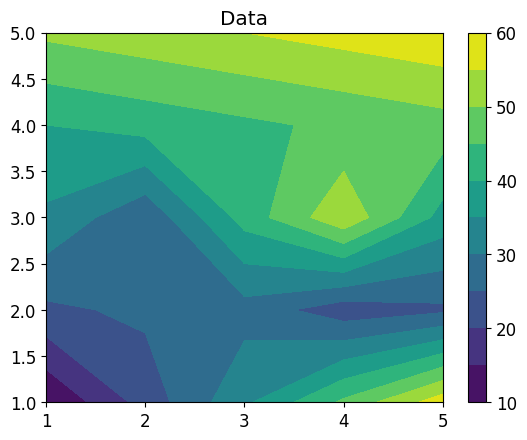

In [43]:
im = plt.contourf(coordx, coordy, bouguer, levels=10)
plt.title('Data')
plt.colorbar()

In [44]:
derivative_x = []
for i in range(0,(len(coordx)-1)):
  for j in range(0,(len(coordx)-1)):
    der = (bouguer[i+1][j+1]-bouguer[i][j])/(coordx[i+1][j+1]-coordx[i][j])
    derivative_x.append(float(der))

derivative_y = []
for i in range(0,(len(coordy)-1)):
  for j in range(0,(len(coordy)-1)):
    der = (bouguer[i][j]-bouguer[i+1][j])/(coordy[i][j]-coordy[i+1][j])
    derivative_y.append(float(der))

# total of both derivatives
derivative_total = np.array(derivative_x) + np.array(derivative_y)

In [45]:
g_der = np.reshape(derivative_total, ((len(coordx)-1), (len(coordx)-1)))
print('Shape of derivative matrix after reshaping:', g_der.shape)

Shape of derivative matrix after reshaping: (4, 4)


In [46]:
xnew = []
for i in range(0,(len(coordx)-1)):
    for j in range (0,(len(coordx)-1)):
      xd=(coordx[i+1][j+1]-coordx[i][j]) * 0.5
      xnew.append(float(xd))

ynew = []
for i in range(0,(len(coordy)-1)):
    for j in range (0,(len(coordy)-1)):
      yd=(coordy[i+1][j+1]-coordy[i][j]) * 0.5
      ynew.append(float(yd))

print("Midpoints of X coordinates:", xnew)
print("Midpoints of Y coordinates:", ynew)

Midpoints of X coordinates: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Midpoints of Y coordinates: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [47]:
coordx_mid = np.reshape(xnew, ((len(coordx)-1), (len(coordx)-1)))
coordy_mid = np.reshape(ynew, ((len(coordy)-1), (len(coordy)-1)))
print('Shape of midpoints matrix after reshaping:', coordx_mid.shape)

Shape of midpoints matrix after reshaping: (4, 4)


In [49]:
addx = coordx[:-1,:-1]
addy = coordy[:-1,:-1]

coordx_der = coordx_mid + addx
coordy_der = coordy_mid + addy
print("The new coordinate X after midpoint:", coordx_der)
print("The new coordinate Y after midpoint:", coordy_der)

The new coordinate X after midpoint: [[1.5 2.5 3.5 4.5]
 [1.5 2.5 3.5 4.5]
 [1.5 2.5 3.5 4.5]
 [1.5 2.5 3.5 4.5]]
The new coordinate Y after midpoint: [[1.5 1.5 1.5 1.5]
 [2.5 2.5 2.5 2.5]
 [3.5 3.5 3.5 3.5]
 [4.5 4.5 4.5 4.5]]


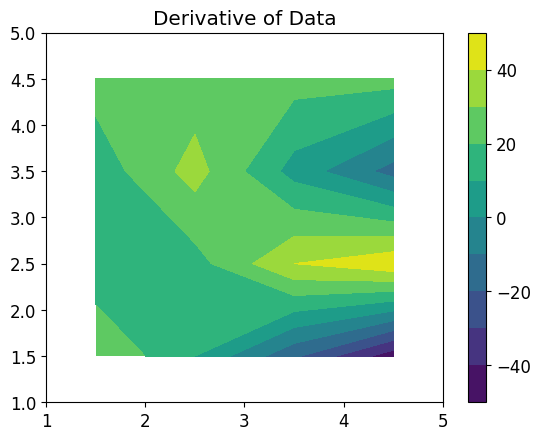

In [50]:
im = plt.contourf(coordx_der, coordy_der, g_der, levels=10)
plt.title('Derivative of Data')
plt.xlim(1, 5); plt.ylim(1, 5)
plt.colorbar(im)

# First Derivative of CBA to X

In [52]:
# first derivative of g to x
f2dx_arr = []
for i in range (0,(len(xi)-1)):
  for j in range (0,(len(xi)-1)):
    fd=(zi[i+1][j+1]-zi[i][j])/(xi[i+1][j+1]-xi[i][j])
    f2dx_arr.append(float(fd))

print("The result is in 1D array \n")
print("Length of the first derivative x:", len(f2dx_arr), "\n")
print("There are:", np.count_nonzero(np.isnan(f2dx_arr)), "NaN values in the first derivative gravity \n")
print("First derivative x:", f2dx_arr)

The result is in 1D array 

Length of the first derivative x: 2401 

There are: 212 NaN values in the first derivative gravity 

First derivative x: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0035017014955944503, 0.0024811724279896006, 0.0005354952389595516, 0.0006779223873420782, 0.0007559007921978889, -0.0009616293444408282, -0.0011153983852954265, 0.0022613431136472356, 0.0018184428139084404, -0.0008092929195340179, -4.7002731484575475e-05, -0.000329265064575765, -0.0017998028682127737, -0.000903132869368071, -0.0003029438775285268, 3.9977227217474775e-05, -0.002647216142289249, -0.0023034183218515296, -0.0014376089943507837, -6.363726321815517e-05, 0.0020669236609827993, 0.0034854991628827034, 0.002881699074858645, 0.00015278771181811347, 0.0020171116

In [53]:
# the new dimension is ((len(xi)-1),(len(xi)-1)) = (49, 49)
g_first_x = np.reshape(f2dx_arr, ((len(xi)-1),(len(xi)-1)))
g_first_x.shape

(49, 49)

In [54]:
x2d_arr = []
for i in range(0,(len(xi)-1)):
    for j in range (0,(len(xi)-1)):
      xd=(xi[i+1][j+1]-xi[i][j]) * 0.5
      x2d_arr.append(float(xd))

# reshape into matrix      
x_first = np.reshape(x2d_arr, ((len(xi)-1),(len(xi)-1)))

# combine with original data to create the new midpoint coordinate
x_new = xi[:-1,:-1]
x_first = x_new+x_first

print("Dimension of the first derivative x coordinate:", x_first.shape, "\n")
print("First derivative x coordinate: ", x_first)

Dimension of the first derivative x coordinate: (49, 49) 

First derivative x coordinate:  [[288210.91252041 289718.36816122 291225.82380204 ... 357553.87199796
  359061.32763878 360568.78327959]
 [288210.91252041 289718.36816122 291225.82380204 ... 357553.87199796
  359061.32763878 360568.78327959]
 [288210.91252041 289718.36816122 291225.82380204 ... 357553.87199796
  359061.32763878 360568.78327959]
 ...
 [288210.91252041 289718.36816122 291225.82380204 ... 357553.87199796
  359061.32763878 360568.78327959]
 [288210.91252041 289718.36816122 291225.82380204 ... 357553.87199796
  359061.32763878 360568.78327959]
 [288210.91252041 289718.36816122 291225.82380204 ... 357553.87199796
  359061.32763878 360568.78327959]]


# First Derivative of CBA to Y

In [55]:
# first derivative of g to y
f2dy_arr = []
for i in range (0,(len(xi)-1)):
  for j in range (0,(len(xi)-1)):
    fd=(zi[i][j]-zi[i+1][j])/(yi[i][j]-yi[i+1][j])
    f2dy_arr.append(float(fd))

print("The result is in 1D array \n")
print("Length of the first derivative y:", len(f2dy_arr), "\n")
print("There are:", np.count_nonzero(np.isnan(f2dy_arr)), "NaN values in the first derivative gravity \n")
print("First derivative y:", f2dy_arr)

The result is in 1D array 

Length of the first derivative y: 2401 

There are: 168 NaN values in the first derivative gravity 

First derivative y: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.003480169184703969, 0.0024372347953336227, 0.0012730549200831369, 5.453123150291722e-05, -2.383145583597994e-05, -2.3831455835956522e-05, -0.00010515622849464303, -0.00018991779969853732, 0.00029300294761314274, -9.908850126913232e-05, 0.00016740038786948428, -0.00034079483616469597, -0.001853862535290227, -0.0011537568250873434, -0.0007235113916876527, -0.002179131206331849, -0.002180692463076071, -0.001744275156262483, -0.0009036899279993869, -0.00034973489191549815, 0.0011332545561787396, 0.002307220589629169, 0.0019193914841619838, -0.00015823959030775023, -0.000

In [56]:
g_first_y = np.reshape(f2dy_arr, ((len(yi)-1),(len(yi)-1)))
g_first_y.shape

(49, 49)

In [57]:
y2d_arr = []
for i in range(0,(len(yi)-1)):
    for j in range (0,(len(yi)-1)):
      yd=(yi[i][j]-yi[i+1][j]) * 0.5
      y2d_arr.append(float(yd))

# reshape into matrix
y_first = np.reshape(y2d_arr, ((len(yi)-1),(len(yi)-1)))

# combine with original data to create the new midpoint coordinate
y_new = yi[:-1,:-1]
y_first = y_new+y_first

print("Dimension of the first derivative y coordinate:", y_first.shape, "\n")
print("First derivative y coordinate: ", y_first)

Dimension of the first derivative y coordinate: (49, 49) 

First derivative y coordinate:  [[4230759.47577551 4230759.47577551 4230759.47577551 ... 4230759.47577551
  4230759.47577551 4230759.47577551]
 [4231973.02622449 4231973.02622449 4231973.02622449 ... 4231973.02622449
  4231973.02622449 4231973.02622449]
 [4233186.57667347 4233186.57667347 4233186.57667347 ... 4233186.57667347
  4233186.57667347 4233186.57667347]
 ...
 [4286582.79642857 4286582.79642857 4286582.79642857 ... 4286582.79642857
  4286582.79642857 4286582.79642857]
 [4287796.34687755 4287796.34687755 4287796.34687755 ... 4287796.34687755
  4287796.34687755 4287796.34687755]
 [4289009.89732653 4289009.89732653 4289009.89732653 ... 4289009.89732653
  4289009.89732653 4289009.89732653]]


# Total of First Derivatives

In [58]:
g_first = g_first_x + g_first_y
print(g_first.shape)
print("There are:", np.count_nonzero(np.isnan(g_first)), "NaN values in the second derivative gravity")

(49, 49)
There are: 213 NaN values in the second derivative gravity


In [59]:
s2dx_arr = []
for i in range (0,(len(x_first)-1)):
  for j in range (0,(len(x_first)-1)):
    sd=(g_first[i+1][j+1]-g_first[i][j])/(x_first[i+1][j+1]-x_first[i][j])
    s2dx_arr.append(float(sd))

print("The result is in 1D array \n")
print("Length of the second derivative x:", len(s2dx_arr), "\n")
print("There are:", np.count_nonzero(np.isnan(s2dx_arr)), "NaN values in the second derivative gravity \n")
print("Second derivative x:", s2dx_arr)

The result is in 1D array 

Length of the second derivative x: 2304 

There are: 206 NaN values in the second derivative gravity 

Second derivative x: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, -2.940973235936691e-06, -2.7162348824073323e-06, 3.711382013186448e-08, 4.2229613460372667e-07, -5.198831201774398e-07, 9.950235372960682e-07, 2.7092171718854272e-06, -7.031525743139376e-07, -1.436824731126786e-06, 1.1255905149778159e-06, -1.7533494641122933e-07, 8.987503222479321e-07, 2.9889704153466847e-06, 6.607963976464191e-07, 1.558516424781394e-08, -8.129098528677409e-07, 1.915553626565782e-06, 1.965757871518365e-06, 2.077929040728555e-06, 1.8609960976302653e-06, 4.2895318934698965e-07, -1.0504628456913984e-06, -1.2941135502154272e-06, 2.2998389572938435e-06, -1.49

In [60]:
g_second_x = np.reshape(s2dx_arr, ((len(xi)-2),(len(xi)-2)))
g_second_x.shape

(48, 48)

# New X Coordinate of Second Derived Data

In [61]:
x2dd_arr = []
for i in range(0,(len(x_first)-1)):
    for j in range (0,(len(x_first)-1)):
      xdd=(x_first[i+1][j+1]-x_first[i][j]) * 0.5
      x2dd_arr.append(float(xdd))

# reshape into matrix
x_second = np.reshape(x2dd_arr, ((len(xi)-2),(len(xi)-2)))

# combine with the midpoint coordinate of first derivative to create the second
# derivative midpoint coordinate
x_new = x_first[:-1,:-1]
x_second = x_new+x_second

print("Dimension of the second derivative x:", x_second.shape, "\n")
print("x_second: ", x_second)

Dimension of the second derivative x: (48, 48) 

x_second:  [[288964.64034082 290472.09598163 291979.55162245 ... 356800.14417755
  358307.59981837 359815.05545918]
 [288964.64034082 290472.09598163 291979.55162245 ... 356800.14417755
  358307.59981837 359815.05545918]
 [288964.64034082 290472.09598163 291979.55162245 ... 356800.14417755
  358307.59981837 359815.05545918]
 ...
 [288964.64034082 290472.09598163 291979.55162245 ... 356800.14417755
  358307.59981837 359815.05545918]
 [288964.64034082 290472.09598163 291979.55162245 ... 356800.14417755
  358307.59981837 359815.05545918]
 [288964.64034082 290472.09598163 291979.55162245 ... 356800.14417755
  358307.59981837 359815.05545918]]


# Second Derivative of CBA to Y

In [62]:
s2dy_arr = []
for i in range (0,(len(y_first)-1)):
  for j in range (0,(len(y_first)-1)):
    sd=(g_first[i][j]-g_first[i+1][j])/(y_first[i][j]-y_first[i+1][j])
    s2dy_arr.append(float(sd))

print("The result is in 1D array \n")
print("Length of the second derivative y:", len(s2dy_arr), "\n")
print("There are:", np.count_nonzero(np.isnan(s2dy_arr)), "NaN values in the second derivative gravity \n")
print("Second derivative y:", s2dy_arr)

The result is in 1D array 

Length of the second derivative y: 2304 

There are: 163 NaN values in the second derivative gravity 

Second derivative y: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, -2.326268651109151e-06, -1.9528839851835467e-06, -8.114590801009024e-07, 9.328363552237736e-07, 5.248870973771386e-07, 7.695019151004939e-07, 1.429728495434175e-06, 6.526673702617518e-07, -9.064244201800422e-07, 7.036193981389057e-07, 5.504498757554659e-07, 4.335607996909206e-07, 3.5749908455500245e-06, 2.3970693647242607e-06, -2.8275024087228596e-08, 9.362549819091137e-07, 1.2058246810413763e-06, 1.7365549113931546e-06, 1.035719806449621e-06, 9.925084593368234e-07, -6.659643264635206e-07, -1.6034880396252307e-06, -4.877398786437706e-07, 2.3531973217749383e-06, 1.3371006

In [63]:
g_second_y = np.reshape(s2dy_arr, ((len(yi)-2),(len(yi)-2)))
g_second_y.shape

(48, 48)

# New Y Coordinate of Second Derived Data

In [64]:
# (g_first[i][j]-g_first[i+1][j])/(y_first[i][j]-y_first[i+1][j])

y2dd_arr = []
for i in range(0,(len(y_first)-1)):
    for j in range (0,(len(y_first)-1)):
      ydd=(y_first[i][j]-y_first[i+1][j]) * 0.5
      y2dd_arr.append(float(ydd))

# reshape into matrix
y_second = np.reshape(y2dd_arr, ((len(yi)-2),(len(yi)-2)))

# combine with the midpoint coordinate of first derivative to create the second
# derivative midpoint coordinate
y_new = y_first[:-1,:-1]
y_second = y_new+y_second

print("Dimension of the second derivative y:", y_second.shape, "\n")
print("y_second: ", y_second)

Dimension of the second derivative y: (48, 48) 

y_second:  [[4230152.70055102 4230152.70055102 4230152.70055102 ... 4230152.70055102
  4230152.70055102 4230152.70055102]
 [4231366.251      4231366.251      4231366.251      ... 4231366.251
  4231366.251      4231366.251     ]
 [4232579.80144898 4232579.80144898 4232579.80144898 ... 4232579.80144898
  4232579.80144898 4232579.80144898]
 ...
 [4284762.4707551  4284762.4707551  4284762.4707551  ... 4284762.4707551
  4284762.4707551  4284762.4707551 ]
 [4285976.02120408 4285976.02120408 4285976.02120408 ... 4285976.02120408
  4285976.02120408 4285976.02120408]
 [4287189.57165306 4287189.57165306 4287189.57165306 ... 4287189.57165306
  4287189.57165306 4287189.57165306]]


# Total of Second Derivatives

In [65]:
g_second = g_second_x + g_second_y
print(g_second.shape)
print("There are:", np.count_nonzero(np.isnan(g_second)), "NaN values in the second derivative gravity")

(48, 48)
There are: 207 NaN values in the second derivative gravity


# Residual Anomaly

Residual Anomaly = minus(Total of Second Derivatives)

In [66]:
# convert from mGal/m2 to mGal/km2
residual = (g_second * -1) * (1E+06)
print(residual.shape)
print("There are:", np.count_nonzero(np.isnan(residual)), "NaN values in the second derivative gravity")

(48, 48)
There are: 207 NaN values in the second derivative gravity


# Regional Anomaly

Interpolate the original Complete Bouguer Anomaly CBA to the x and y coordinates of residual anomaly x_second and y_second in 48 x 48 dimension

In [68]:
# Interpolation
zi_cba = griddata((utm_x,utm_y),CBA,(x_second,y_second),method='cubic')

In [69]:
regional = zi_cba - residual

In [70]:
print("Dimension of X Coordinate for plotting:", x_second.shape, "\n")
print("Dimension of Y Coordinate for plotting:", y_second.shape, "\n")
print("X Coordinate for residual anomaly:", x_second, "\n")
print("Y Coordinate for residual anomaly:", y_second, "\n")

Dimension of X Coordinate for plotting: (48, 48) 

Dimension of Y Coordinate for plotting: (48, 48) 

X Coordinate for residual anomaly: [[288964.64034082 290472.09598163 291979.55162245 ... 356800.14417755
  358307.59981837 359815.05545918]
 [288964.64034082 290472.09598163 291979.55162245 ... 356800.14417755
  358307.59981837 359815.05545918]
 [288964.64034082 290472.09598163 291979.55162245 ... 356800.14417755
  358307.59981837 359815.05545918]
 ...
 [288964.64034082 290472.09598163 291979.55162245 ... 356800.14417755
  358307.59981837 359815.05545918]
 [288964.64034082 290472.09598163 291979.55162245 ... 356800.14417755
  358307.59981837 359815.05545918]
 [288964.64034082 290472.09598163 291979.55162245 ... 356800.14417755
  358307.59981837 359815.05545918]] 

Y Coordinate for residual anomaly: [[4230152.70055102 4230152.70055102 4230152.70055102 ... 4230152.70055102
  4230152.70055102 4230152.70055102]
 [4231366.251      4231366.251      4231366.251      ... 4231366.251
  4231366.

# (Re-gridded) Complete Bouguer Anomaly

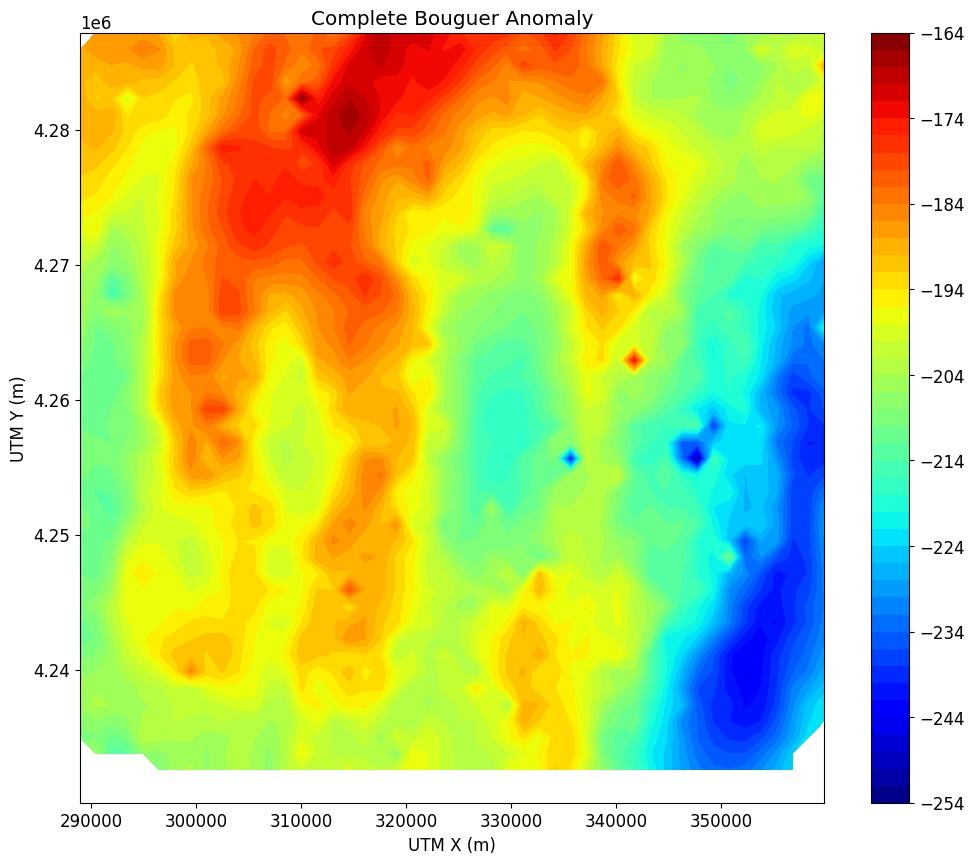

In [71]:
# plot re-gridded CBA contour
fig, ax = plt.subplots(figsize=(12,10))
im = ax.contourf(x_second,y_second,zi_cba,levels=50, cmap="jet")
ax.set_title('Complete Bouguer Anomaly')
ax.set_xlabel('UTM X (m)'); plt.ylabel('UTM Y (m)')
plt.colorbar(im)

# Residual Anomaly

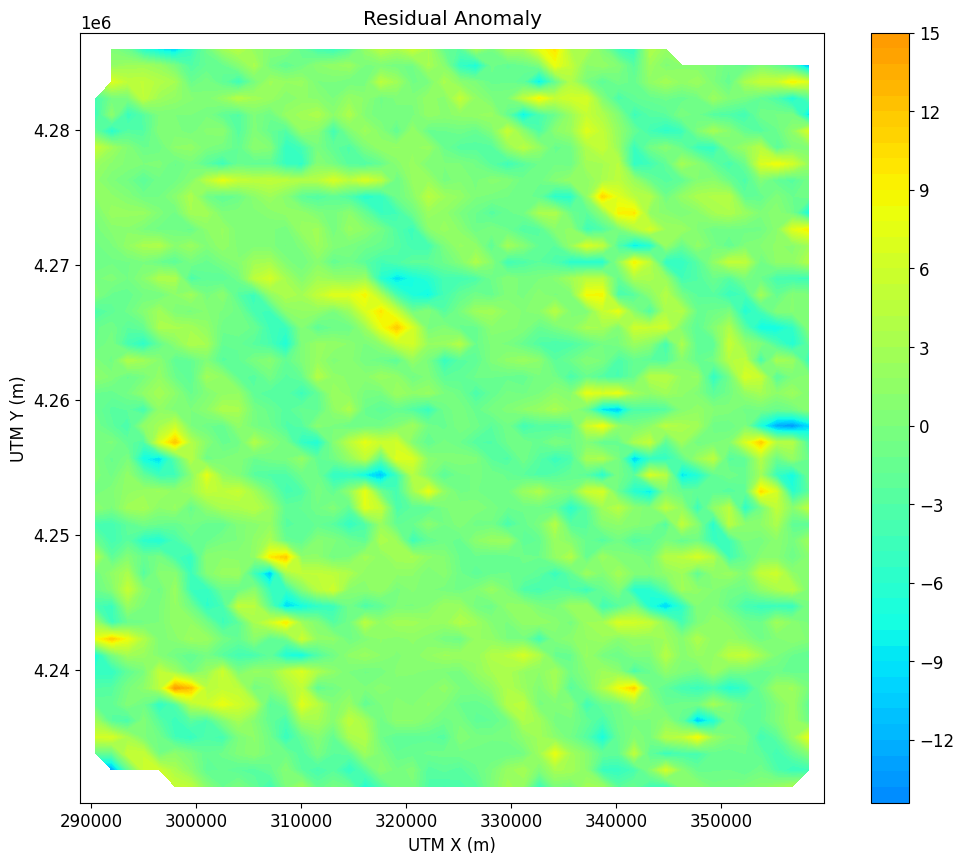

In [72]:
fig, ax = plt.subplots(figsize=(12,10))

# plot residual contours
im = ax.contourf(x_second,y_second,residual,levels=50, cmap="jet", vmin=-30, vmax=30)
ax.set_title('Residual Anomaly')
ax.set_xlabel('UTM X (m)'); plt.ylabel('UTM Y (m)')
plt.colorbar(im)

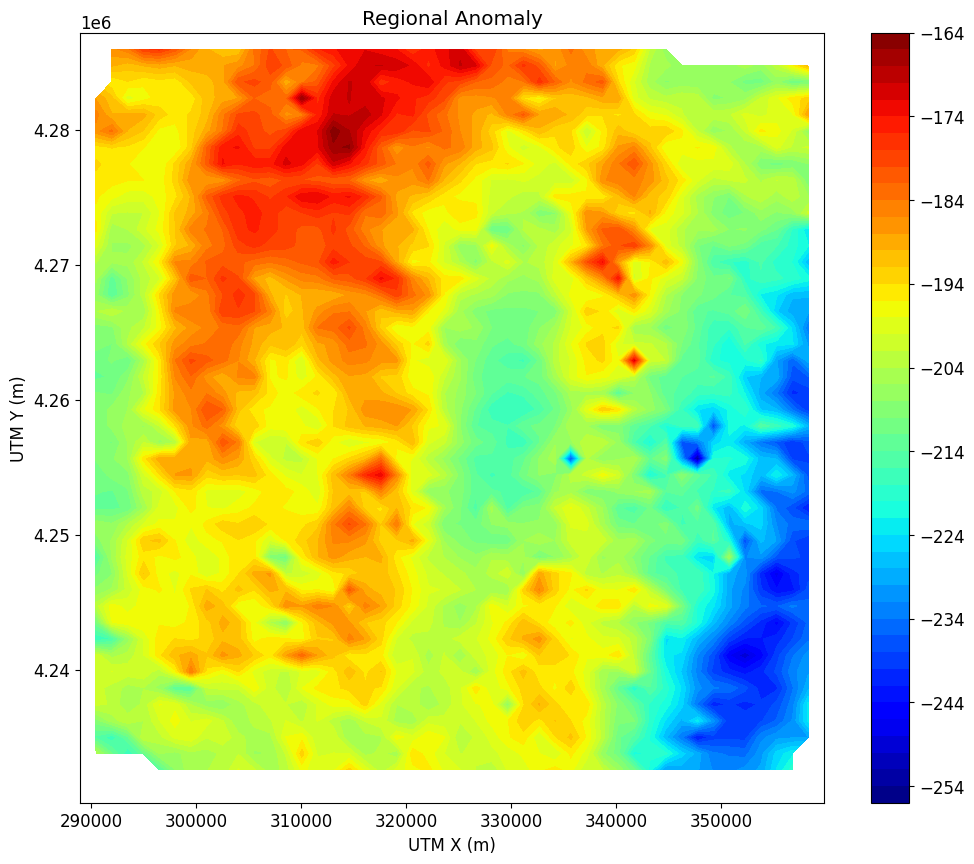

In [73]:
# plot re-gridded regional anomaly contour
fig, ax = plt.subplots(figsize=(12,10))
im = ax.contourf(x_second,y_second,regional,levels=50, cmap="jet")
ax.set_title('Regional Anomaly')
ax.set_xlabel('UTM X (m)'); plt.ylabel('UTM Y (m)')
plt.colorbar(im)

# All anomalies

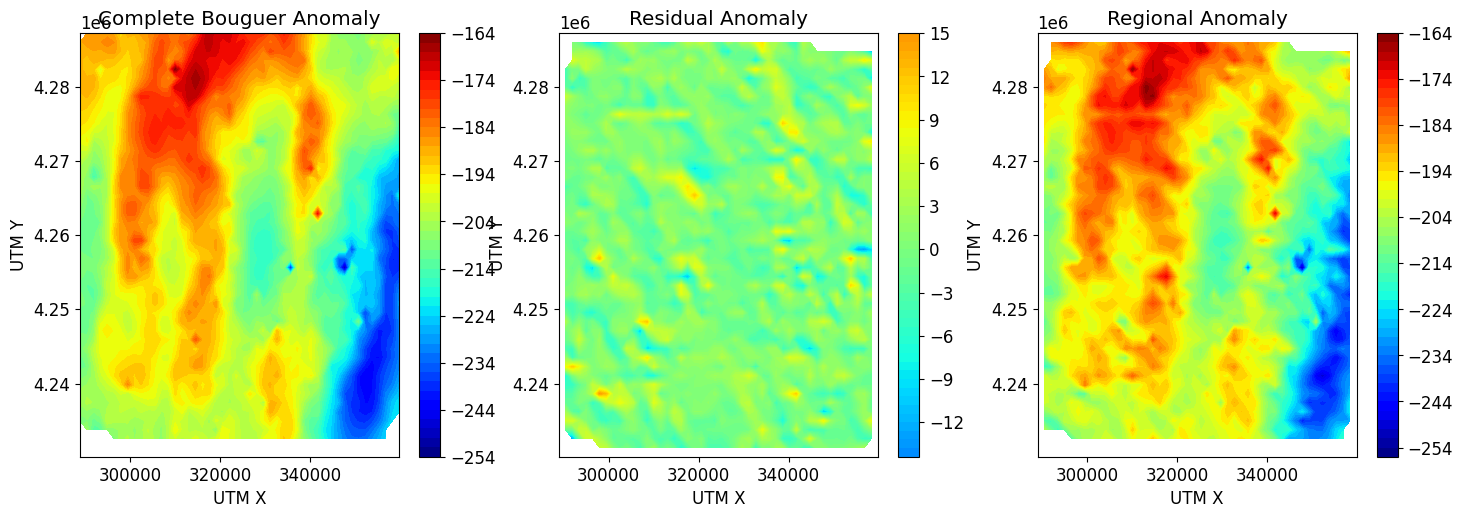

In [74]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(17.5,5.5))
axs = axs.flatten()

im = axs[0].contourf(x_second,y_second,zi_cba,levels=50, cmap="jet")
axs[0].set_title('Complete Bouguer Anomaly')
axs[0].set_xlabel('UTM X'); axs[0].set_ylabel('UTM Y')
fig.colorbar(im, ax=axs[0])


im = axs[1].contourf(x_second,y_second,residual,levels=50, cmap="jet", vmin=-30, vmax=30)
axs[1].set_title('Residual Anomaly')
axs[1].set_xlabel('UTM X'); axs[1].set_ylabel('UTM Y')
fig.colorbar(im, ax=axs[1])

im = axs[2].contourf(x_second,y_second,regional,levels=50, cmap="jet")
axs[2].set_title('Regional Anomaly')
axs[2].set_xlabel('UTM X'); axs[2].set_ylabel('UTM Y')
fig.colorbar(im, ax=axs[2])

In [77]:
topo_filename ="gravity_topo.txt"
data_filename = "Gravity_UTM.txt"